In [1]:
import sys
sys.path.append('../')
from src.dataset import read_folder
import cv2
import numpy as np

In [2]:
PATH = '../LaPa/examples'

In [3]:
images = read_folder(PATH, n = None, landmarks= 'landmarks', RGB = True)

In [4]:
# At the beginning, lets find face landmarks (focusing on the contour)

In [256]:
import dlib
from imutils import face_utils
from scipy.spatial import ConvexHull

In [282]:
from src.visualization import plot_img, plot_hist_with_component

In [273]:
from ipynb.fs.defs.skinDetection import avg_color, plot_diffrent_color_palette_with_components, simple_tresholding

In [14]:
#sys.path.append('../FaceLandmarks')

In [18]:
#import import_ipynb
#import FaceLandmarks.faceLandmarks as faceLandmarks

In [54]:
#dir(faceLandmarks.__builtins__)

In [294]:
def face_detec_plot(img, rects, ax = plt):
    ax.imshow(img)
    ax.plot([rects[0].bottom(), rects[0].bottom(), rects[0].top(), rects[0].top(), rects[0].bottom()], 
             [rects[0].right(),rects[0].left(), rects[0].left(), rects[0].right(), rects[0].right()])
    ax.axis('off')

In [56]:
def detect_face(gray, img, DETECTOR, plot = True):
    rects = DETECTOR(gray, 1)
    if plot:
        if len(rects) == 0: 
            raise ValueError("Ops! Face has not been detected", rects)
        else:
            face_detec_plot(img, rects)
    return rects

In [57]:
def face_predict_landmarks(gray, rect, PREDICTOR):
    """predict face landmarks using PREDICTOR dlib's object,
    rects is the bounding box to begin the shape prediction inside. """
    landmarks = PREDICTOR(gray, rect) # http://dlib.net/python/index.html#dlib.shape_predictor (__call__ method)
    landmarks = face_utils.shape_to_np(landmarks)
    
    # now let's return object Landmarks, Class Landmarks is defined in src/landmarks.py file, 
    # more about it you can find in notebook: /MeetDataset/meetDataset.ipynb
    return Landmarks(landmarks) 

In [58]:
DETECTOR = dlib.get_frontal_face_detector() #the default face detector
PREDICTOR = dlib.shape_predictor("../FaceLandmarks/shape_predictor_68_face_landmarks.dat")

In [59]:
example_img = list(images.keys())[6]
img_RGB = images[example_img]['img']
gray = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2GRAY)

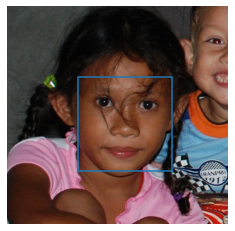

In [138]:
rects = detect_face(gray, img_RGB, DETECTOR)

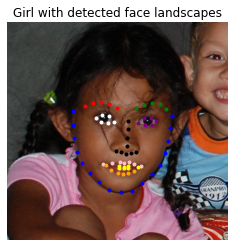

In [63]:
landmarks = face_predict_landmarks(gray, rects[0], PREDICTOR)
plot_img(img_RGB)
plot_landmarks_color(landmarks)
plt.title('Girl with detected face landscapes')
plt.show()

In [187]:
x = landmarks()[:,0]
y = landmarks()[:,1]

hight = max(y) - min(y)

new_rect = dlib.rectangle(max(y), min(x), max(min(y) - hight//2,0), max(x))

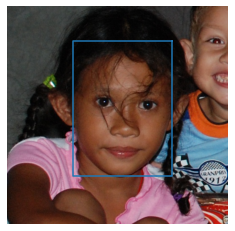

In [189]:
face_detec_plot(img_RGB, [new_rect])

In [192]:
landmarks.points_info['CONTOURS']

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [262]:
def find_mask_from_landmarks(img, landmarks, full_mask = True, plot = True):
    contours = np.take(landmarks(), landmarks.points_info['CONTOURS'], axis = 0)
    img_mask = np.zeros_like(img) # create a single channel 200x200 pixel black image 
    cv2.fillPoly(img_mask, pts =[contours], color=(255,255,255))
    if full_mask == False:
        
        l_eye = np.take(landmarks(), landmarks.points_info['LEFT_EYE'], axis = 0)
        r_eye = np.take(landmarks(), landmarks.points_info['REIGHT_EYE'], axis = 0)
        
        nose = np.take(landmarks(), landmarks.points_info['NOSE_POINTS'], axis = 0)
        hull = ConvexHull(nose)
        nose = nose[hull.vertices]
        #nose = np.array([[*nose[(nose==min(nose[:,0]))[:,0]][0]], [*nose[(nose==max(nose[:,0]))[:,0]][0]], 
        #        [*nose[(nose==min(nose[:,1]))[:,1]][0]], [*nose[(nose==max(nose[:,1]))[:,1]][0]]])
        
        lips = np.take(landmarks(), landmarks.points_info['UPPER_LIP'] + landmarks.points_info['BOTTOM_LIP'], axis = 0)
        
        for i in [l_eye, r_eye , nose, lips]:
            cv2.fillPoly(img_mask, pts =[i], color=(0,0,0))     
        
    if plot:
        plot_img(img_mask, alpha = 0.5)
    return img_mask, contours

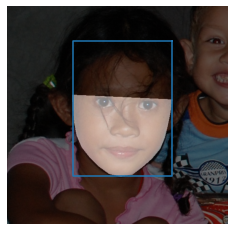

In [263]:
face_detec_plot(img_RGB, [new_rect])
_ = find_mask_from_landmarks(img_RGB, landmarks)

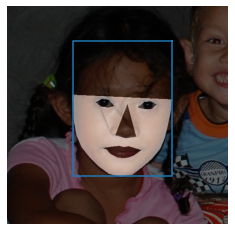

In [264]:
face_detec_plot(img_RGB, [new_rect])
img_mask, contours = find_mask_from_landmarks(img_RGB, landmarks, False)

In [270]:
img_BGR = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2BGR)

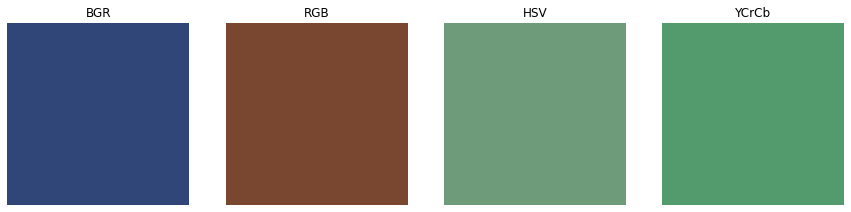

In [271]:
avgs = avg_color(img_BGR,  img_mask[:,:,0] == 255)

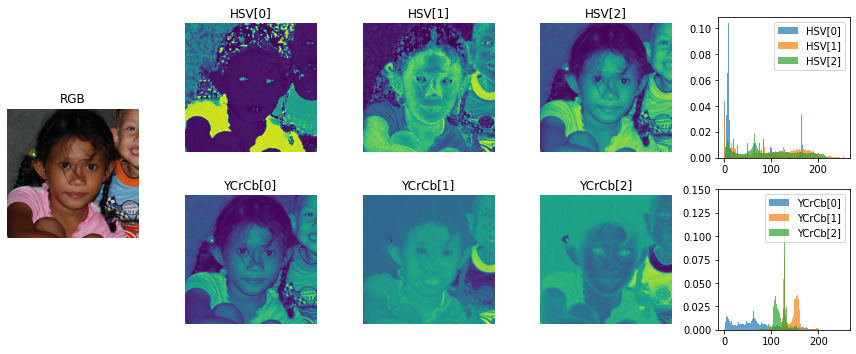

In [272]:
plot_diffrent_color_palette_with_components(img_BGR)

In [276]:
avgs

[(48.42768615692154, 70.66186906546727, 121.20029985007496),
 (121.20029985007496, 70.66186906546727, 48.42768615692154),
 (110.91007829418623, 155.52293853073462, 121.20782941862402),
 (83.25850408129268, 155.1006829918374, 108.34702648675662)]

In [277]:
img_YCrCb = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2YCrCb)

In [278]:
component = img_YCrCb[:,:,2]

In [284]:
treshold_range = [avgs[-1][-1] - 10, avgs[-1][-1] + 10]

In [286]:
mask_created_via_treshold = (cv2.inRange(component, * treshold_range)/255).astype(int)

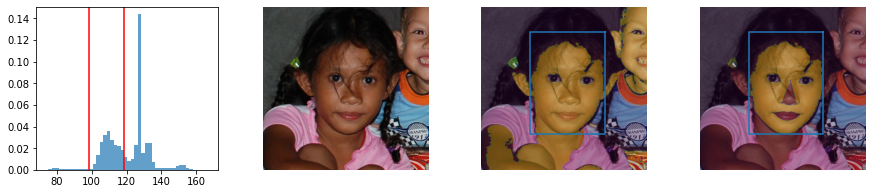

In [345]:
f, axs = plt.subplots(1,4, figsize=(15,3))

plot_hist_with_component(component, axs[0])
axs[0].axvline(x=treshold_range[0], color = 'r')
axs[0].axvline(x=treshold_range[1], color = 'r')

plot_img(img_RGB, ax = axs[1])

face_detec_plot(img_RGB, [new_rect], axs[2])
plot_img(mask_created_via_treshold, alpha = 0.25, ax = axs[2])

first = landmarks.points_info['CONTOURS'][0]
last = landmarks.points_info['CONTOURS'][-1]

i = np.array([[x[first],y[last]],
                            [x[last],y[last]],
                             [x[last], max(min(y) - hight//2,0)],
                            [x[first], max(min(y) - hight//2,0)]])

_ = cv2.fillPoly(img_mask, pts = [i], color=(255,255,255)) 


new_mask = np.where( (mask_created_via_treshold == (img_mask[:,:,0]/255).astype(int)) & (mask_created_via_treshold == 1),
         np.ones_like(mask_created_via_treshold), np.zeros_like(mask_created_via_treshold) )

face_detec_plot(img_RGB, [new_rect], axs[3])
plot_img(new_mask, alpha = 0.25, ax = axs[3])